# Imports

In [1]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=0'
import tensorflow as tf
from tensorflow.keras import layers, models
from PIL import ImageFont
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
from sklearn.utils import shuffle
from tqdm import tqdm
from glob import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import visualkeras
from tensorflow.keras import layers
import pandas as pd
import tensorflow_model_optimization as tfmot
from tqdm.keras import TqdmCallback

# Data Preparation

In [ ]:
# Constants
RTM_PATH = r'\\ML-on-Microcontrollers-Project-Ioana-Gidiuta\\Datasets\\11G-features\\RTM_images'
DTM_PATH = r'\\ML-on-Microcontrollers-Project-Ioana-Gidiuta\\Datasets\\11G-features\\DTM_images'
ATM_PATH = r'\\ML-on-Microcontrollers-Project-Ioana-Gidiuta\\Datasets\\11G-features\\ATM_images'

IMG_SIZE = (32, 32)
SEQ_LEN = 5

In [4]:
# Function to load image and resize to 32X32X1 - grayscale
def load_and_resize_image(path):
    img = load_img(path, color_mode='grayscale', target_size=(32, 32))
    return img_to_array(img) / 255.0

# Index data correctly with session under person -> session -> gesture
def index_multi_image_sequences(rtm_path, dtm_path, atm_path, seq_len=5, exclude_participants=None):
    all_train_samples, test_samples = [], []
    gesture_set = set()
    exclude_participants = set(exclude_participants or [])

    participants = sorted([p for p in os.listdir(rtm_path) if os.path.isdir(os.path.join(rtm_path, p))])  

    for person in participants:
        print(f"Processing participant: {person}")
        is_test_person = person in exclude_participants
        rtm_person_path = os.path.join(rtm_path, person)

        for session in os.listdir(rtm_person_path):
            rtm_sess_path = os.path.join(rtm_person_path, session)
            if not os.path.isdir(rtm_sess_path):
                continue

            for gesture in os.listdir(rtm_sess_path):
                rtm_gesture_path = os.path.join(rtm_sess_path, gesture)
                dtm_gesture_path = os.path.join(dtm_path, person, session, gesture)
                atm_gesture_path = os.path.join(atm_path, person, session, gesture)

                if not all(map(os.path.isdir, [rtm_gesture_path, dtm_gesture_path, atm_gesture_path])):
                    continue

                gesture_set.add(gesture)

                rtm_files = sorted(glob(os.path.join(rtm_gesture_path, '*.png')))
                dtm_files = sorted(glob(os.path.join(dtm_gesture_path, '*.png')))
                atm_files = sorted(glob(os.path.join(atm_gesture_path, '*.png')))

                num_frames = min(len(rtm_files), len(dtm_files), len(atm_files))
                for i in range(num_frames - seq_len + 1):
                    sample = {
                        'rtm': rtm_files[i:i+seq_len],
                        'dtm': dtm_files[i:i+seq_len],
                        'atm': atm_files[i:i+seq_len],
                        'label': gesture
                    }
                    if is_test_person:
                        test_samples.append(sample)
                    else:
                        all_train_samples.append(sample)

    # 80/20 train/val split
    train_samples, val_samples = train_test_split(
        all_train_samples, test_size=0.2, random_state=42, shuffle=True
    )

    label_map = {gesture: idx for idx, gesture in enumerate(sorted(gesture_set))}
    return train_samples, val_samples, test_samples, label_map

# DataLoader
class MultiRadarSequenceGenerator(Sequence):
    def __init__(self, samples, label_map, batch_size=32, seq_len=SEQ_LEN, shuffle_data=False):
        self.samples = samples
        self.label_map = label_map
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.shuffle_data = shuffle_data
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.samples) / self.batch_size))

    def __getitem__(self, index):
        batch_samples = self.samples[index * self.batch_size:(index + 1) * self.batch_size]
        X_rtm, X_dtm, X_atm, y = self.__load_batch(batch_samples)
        return [X_rtm, X_dtm, X_atm], y

    def on_epoch_end(self):
        if self.shuffle_data:
            self.samples = shuffle(self.samples)

    def __load_batch(self, batch_samples):
        X_rtm, X_dtm, X_atm, y = [], [], [], []
        for sample in batch_samples:
            try:
                rtm_seq = [load_and_resize_image(p) for p in sample['rtm']]
                dtm_seq = [load_and_resize_image(p) for p in sample['dtm']]
                atm_seq = [load_and_resize_image(p) for p in sample['atm']]
                if len(rtm_seq) == self.seq_len:
                    X_rtm.append(rtm_seq)
                    X_dtm.append(dtm_seq)
                    X_atm.append(atm_seq)
                    y.append(self.label_map[sample['label']])
            except Exception as e:
                print(f"Error loading sample: {e}")
        return (
            np.array(X_rtm),
            np.array(X_dtm),
            np.array(X_atm),
            np.array(y)
        )

In [5]:
# Index sequences
excluded = {f'p0_{i}' for i in range(15, 21)}  # p0_15 to p0_20
train_samples, val_samples, test_samples, label_map = index_multi_image_sequences(
    RTM_PATH, DTM_PATH, ATM_PATH, seq_len=5, exclude_participants=excluded
)

# Create generators
train_gen = MultiRadarSequenceGenerator(train_samples, label_map, batch_size=256, shuffle_data=True)
val_gen = MultiRadarSequenceGenerator(val_samples, label_map, batch_size=256, shuffle_data=False)

Processing participant: p0_1
Processing participant: p0_10
Processing participant: p0_11
Processing participant: p0_12
Processing participant: p0_13
Processing participant: p0_14
Processing participant: p0_15
Processing participant: p0_16
Processing participant: p0_17
Processing participant: p0_18
Processing participant: p0_19
Processing participant: p0_2
Processing participant: p0_20
Processing participant: p0_3
Processing participant: p0_4
Processing participant: p0_5
Processing participant: p0_6
Processing participant: p0_7
Processing participant: p0_8
Processing participant: p0_9
Processing participant: p1
Processing participant: p10
Processing participant: p11
Processing participant: p12
Processing participant: p13
Processing participant: p14
Processing participant: p15
Processing participant: p16
Processing participant: p17
Processing participant: p18
Processing participant: p19
Processing participant: p2
Processing participant: p20
Processing participant: p21
Processing particip

In [6]:
# how many train samples are there?
print(f"Number of training samples: {len(train_samples)}")
# how many test samples are there?
print(f"Number of val samples: {len(val_samples)}")
# how many test samples are there?
print(f"Number of test samples: {len(test_samples)}")
# what is the shape of the sample?
print(f"Shape of a single sample: {train_gen[0][0][0].shape}")

Number of training samples: 6489
Number of val samples: 1623
Number of test samples: 1166
Shape of a single sample: (256, 5, 32, 32, 1)


# Model

In [43]:
def build_single_cnn(input_shape=(32, 32, 1)):
    input_layer = tf.keras.Input(shape=input_shape)
    x = layers.Conv2D(16, (5, 5), activation='relu', padding='same')(input_layer)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    return models.Model(inputs=input_layer, outputs=x)

# Multi-CNN with Depthwise Temporal Conv1D
def build_multi_cnn_conv1d(seq_len=5, img_shape=(32, 32, 1), num_classes=13):
    # Inputs
    rtm_input = tf.keras.Input(shape=(seq_len, *img_shape), name="rtm_input")
    dtm_input = tf.keras.Input(shape=(seq_len, *img_shape), name="dtm_input")
    atm_input = tf.keras.Input(shape=(seq_len, *img_shape), name="atm_input")

    cnn_encoder = build_single_cnn(img_shape)

    # Encode each frame with CNN
    rtm_encoded = layers.TimeDistributed(cnn_encoder)(rtm_input)  # (batch, 5, 128)
    dtm_encoded = layers.TimeDistributed(cnn_encoder)(dtm_input)
    atm_encoded = layers.TimeDistributed(cnn_encoder)(atm_input)

    # Fuse all three sequences into (batch, 5, 128 * 3)
    merged = layers.Concatenate(axis=-1)([rtm_encoded, dtm_encoded, atm_encoded])  # (batch, 5, 384)

    # Depthwise Separable 1D Conv block to replace LSTM
    x = layers.SeparableConv1D(128, kernel_size=3, padding="same", activation="relu")(merged)
    x = layers.GlobalAveragePooling1D()(x)  # shape: (batch, 128)

    x = layers.Dense(64, activation='relu')(x)
    output = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs=[rtm_input, dtm_input, atm_input], outputs=output)

# Training and Testing

In [44]:
# Custom TQDM callback
class TQDMProgressCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_gen):
        super().__init__()
        self.test_gen = test_gen

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_pbar = tqdm(total=1, desc=f"Epoch {epoch+1}", unit="epoch")

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_pbar.update(1)
        self.epoch_pbar.close()
        loss, acc = self.model.evaluate(self.test_gen, verbose=0)
        print(f"Epoch {epoch+1}: Test Accuracy = {acc:.4f}")

class BatchCheckpoint(Callback):
    def __init__(self, save_dir, label_map, every_n_batches=100):
        super().__init__()
        self.save_dir = save_dir
        self.every_n_batches = every_n_batches
        self.batch_count = 0
        self.label_map = label_map
        os.makedirs(save_dir, exist_ok=True)

    def on_train_batch_end(self, batch, logs=None):
        self.batch_count += 1
        if self.batch_count % self.every_n_batches == 0:
            filename = os.path.join(self.save_dir, f"batch_{self.batch_count:06d}.h5")
            self.model.save(filename, save_format="tf")
            print(f"Saved model at batch {self.batch_count} to {filename}")

In [45]:
class SaveLossAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, filepath='training_log_2.txt'):
        super().__init__()
        self.filepath = filepath
        with open(self.filepath, 'w') as f:
            f.write("epoch,loss,accuracy,val_loss,val_accuracy\n")

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        line = f"{epoch+1},{logs.get('loss'):.4f},{logs.get('accuracy'):.4f},{logs.get('val_loss'):.4f},{logs.get('val_accuracy'):.4f}\n"
        with open(self.filepath, 'a') as f:
            f.write(line)

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
model = build_multi_cnn_conv1d(num_classes=len(label_map))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Checkpoint callbacks
checkpoint_cb = ModelCheckpoint(
    filepath='Models/3_radar_CNN_1DC/best_model_epoch{epoch:02d}_valacc{val_accuracy:.4f}.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

batch_checkpoint_cb = BatchCheckpoint(
    save_dir='Models/3_radar_CNN_1DC/batch_checkpoints',
    label_map=label_map,
    every_n_batches=2500
)

log_callback = SaveLossAccuracy(r"C:\Users\ioana\Documents\VS Projects\ML-on-Microcontrollers-Project-Ioana-Gidiuta\Code\model_training_grayscale_images\Models\3_radar_CNN_1DC\training_log.txt")

model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[
        TQDMProgressCallback(val_gen),
        checkpoint_cb,
        batch_checkpoint_cb,
        log_callback
    ],
    workers=4,
    use_multiprocessing=False,
)
model.save("Models/3_radar_CNN/final_model.h5", save_format="tf")

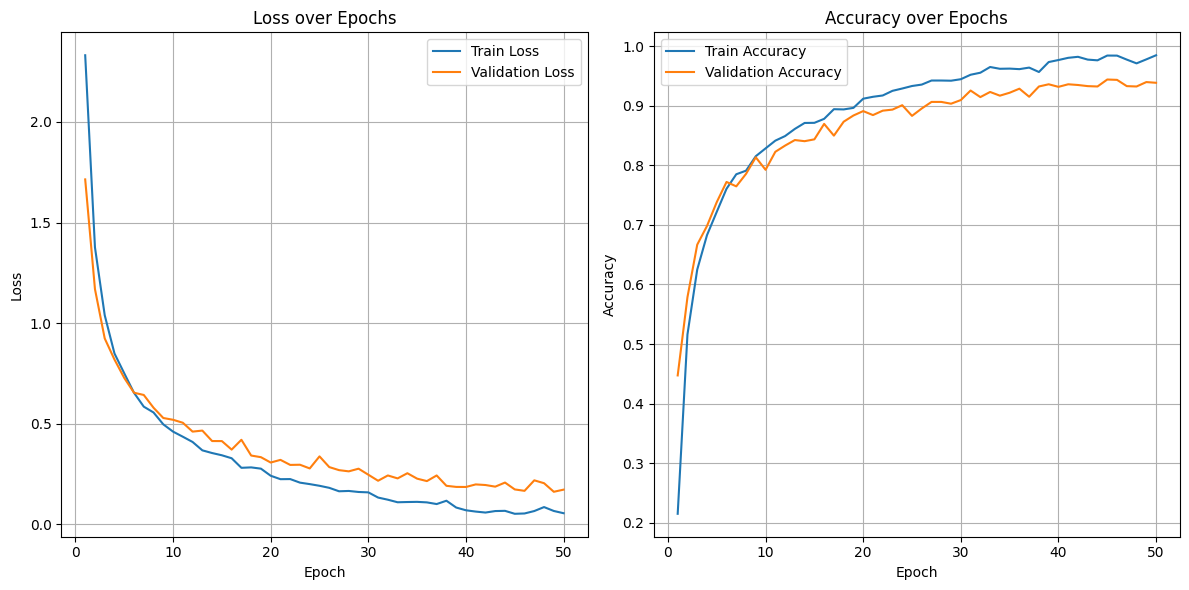

In [12]:
# Load the training log
log_df = pd.read_csv(r"C:\Users\ioana\Documents\VS Projects\ML-on-Microcontrollers-Project-Ioana-Gidiuta\Code\model_training_grayscale_images\Models\3_radar_CNN_1DC\training_log.txt")#, sep="\t")

# Plot
if 'epoch' not in log_df.columns:
    log_df['epoch'] = range(1, len(log_df) + 1)

# Plot
plt.figure(figsize=(12, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(log_df['epoch'], log_df['loss'], label='Train Loss')
plt.plot(log_df['epoch'], log_df['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(log_df['epoch'], log_df['accuracy'], label='Train Accuracy')
plt.plot(log_df['epoch'], log_df['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Testing

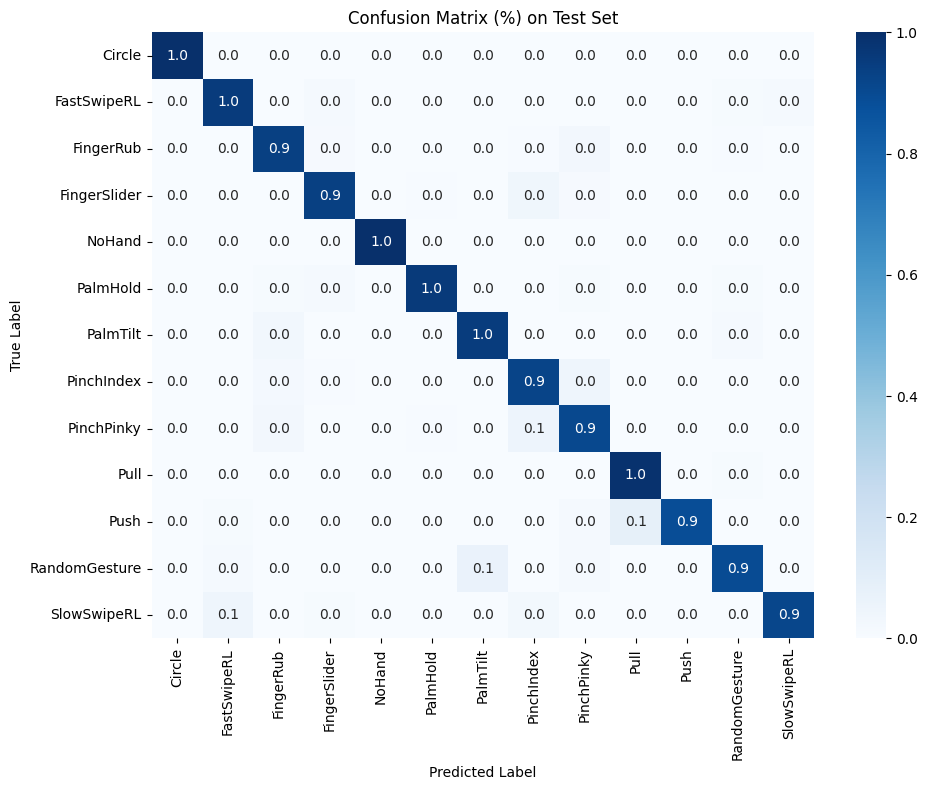

               precision    recall  f1-score   support

       Circle       1.00      1.00      1.00       123
  FastSwipeRL       0.92      0.96      0.94       115
    FingerRub       0.91      0.94      0.92       129
 FingerSlider       0.95      0.94      0.94       149
       NoHand       1.00      1.00      1.00       124
     PalmHold       0.98      0.96      0.97       119
     PalmTilt       0.94      0.95      0.95       127
   PinchIndex       0.88      0.92      0.90       133
   PinchPinky       0.88      0.91      0.89       133
         Pull       0.92      0.99      0.95       117
         Push       1.00      0.89      0.94       116
RandomGesture       0.95      0.90      0.92       118
  SlowSwipeRL       0.98      0.92      0.95       120

     accuracy                           0.94      1623
    macro avg       0.95      0.94      0.94      1623
 weighted avg       0.95      0.94      0.94      1623



In [14]:
test_gen = MultiRadarSequenceGenerator(
    test_samples,
    label_map,
    batch_size=32,
    seq_len=SEQ_LEN,
    shuffle_data=False
)

best_model_path = r'C:\Users\ioana\Documents\VS Projects\ML-on-Microcontrollers-Project-Ioana-Gidiuta\Code\model_training_grayscale_images\Models\3_radar_CNN_1DC\best_model_epoch45_valacc0.9439.h5'
model = tf.keras.models.load_model(best_model_path)

# Predict on test generator
y_true = []
y_pred = []

for X, y in val_gen:
    preds = model.predict(X, verbose=0)
    y_true.extend(y)
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True)
gesture_names = list(label_map.keys())

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=gesture_names, yticklabels=gesture_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (%) on Test Set')
plt.tight_layout()
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=gesture_names))

In [15]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 rtm_input (InputLayer)      [(None, 5, 32, 32, 1)]       0         []                            
                                                                                                  
 dtm_input (InputLayer)      [(None, 5, 32, 32, 1)]       0         []                            
                                                                                                  
 atm_input (InputLayer)      [(None, 5, 32, 32, 1)]       0         []                            
                                                                                                  
 time_distributed (TimeDist  (None, 5, 128)               524832    ['rtm_input[0][0]']           
 ributed)                                                                                   

# Coversion to TFlite

In [ ]:
model = tf.keras.models.load_model(
    r'\Code\model_training_grayscale_images\Models\3_radar_CNN_1DC\best_model_epoch45_valacc0.9439.h5'
)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    #tf.lite.OpsSet.SELECT_TF_OPS
]
converter._experimental_lower_tensor_list_ops = False

# Keep everything float32
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32

# Convert
tflite_model = converter.convert()

# Save
save_path = "mmWave_1DC_float32.tflite"
with open(save_path, "wb") as f:
    f.write(tflite_model)

print("Float32 TFLite model saved successfully")
print(f"Model size: {os.path.getsize(save_path) / 1024:.2f} KB")

INFO:tensorflow:Assets written to: C:\Users\ioana\AppData\Local\Temp\tmp9aqatf35\assets


INFO:tensorflow:Assets written to: C:\Users\ioana\AppData\Local\Temp\tmp9aqatf35\assets


Float32 TFLite model saved successfully
Model size: 2292.86 KB


# Float 16 Quantizatoin

In [ ]:
# Load your model
best_model_path = r'\Code\model_training_grayscale_images\Models\3_radar_CNN_1DC\best_model_epoch45_valacc0.9439.h5'
model = tf.keras.models.load_model(best_model_path)

# Wrap the model in a tf.function with a defined input signature
@tf.function(input_signature=[
    tf.TensorSpec(shape=[1, 5, 32, 32, 1], dtype=tf.float32, name="rtm_input"),
    tf.TensorSpec(shape=[1, 5, 32, 32, 1], dtype=tf.float32, name="dtm_input"),
    tf.TensorSpec(shape=[1, 5, 32, 32, 1], dtype=tf.float32, name="atm_input")
])
def wrapped_model(rtm, dtm, atm):
    return model([rtm, dtm, atm])

# Extract a concrete function
concrete_func = wrapped_model.get_concrete_function()

# Set up the converter from the concrete function
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

# Needed for models with LSTM
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
converter._experimental_lower_tensor_list_ops = False

# Keep float32 I/O for compatibility (optional)
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32

# Convert the model
try:
    tflite_model_fp16 = converter.convert()
    save_path = "mmWave_1DC_float16.tflite"
    with open(save_path, "wb") as f:
        f.write(tflite_model_fp16)
    print("Float16 quantization successful")
    print(f"Model size: {os.path.getsize(save_path) / 1024:.2f} KB")
except Exception as e:
    print(f"Float16 quantization failed: {str(e)}")

Float16 quantization successful
Model size: 1151.90 KB


In [ ]:
interpreter = tf.lite.Interpreter(model_path=r"\Code\model_training_grayscale_images\mmWave_1DC_float16.tflite")
interpreter.allocate_tensors()

# Get input and output tensor details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [30]:
for i, d in enumerate(input_details):
    print(f"Input {i}: shape={d['shape']}, dtype={d['dtype']}, quant={d['quantization']}")

for i, d in enumerate(output_details):
    print(f"Output {i}: shape={d['shape']}, dtype={d['dtype']}, quant={d['quantization']}")

Input 0: shape=[ 1  5 32 32  1], dtype=<class 'numpy.float32'>, quant=(0.0, 0)
Input 1: shape=[ 1  5 32 32  1], dtype=<class 'numpy.float32'>, quant=(0.0, 0)
Input 2: shape=[ 1  5 32 32  1], dtype=<class 'numpy.float32'>, quant=(0.0, 0)
Output 0: shape=[ 1 13], dtype=<class 'numpy.float32'>, quant=(0.0, 0)


In [31]:
test_gen = MultiRadarSequenceGenerator(
    test_samples,
    label_map,
    batch_size=32,
    seq_len=SEQ_LEN,
    shuffle_data=False
)

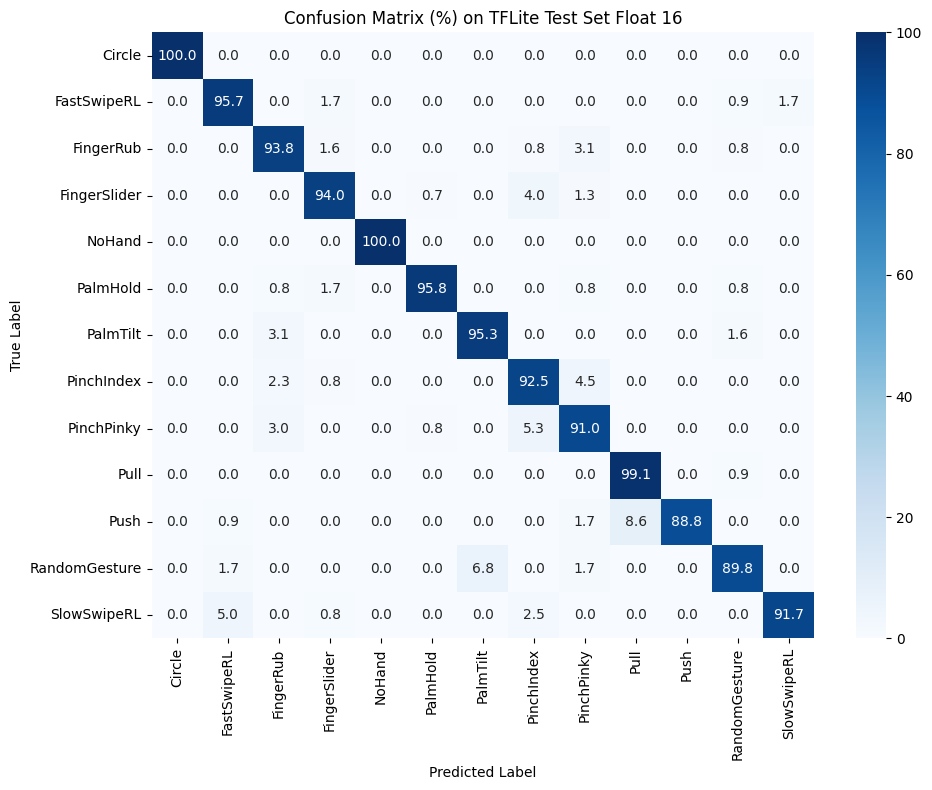

               precision    recall  f1-score   support

       Circle       1.00      1.00      1.00       123
  FastSwipeRL       0.92      0.96      0.94       115
    FingerRub       0.91      0.94      0.92       129
 FingerSlider       0.95      0.94      0.94       149
       NoHand       1.00      1.00      1.00       124
     PalmHold       0.98      0.96      0.97       119
     PalmTilt       0.94      0.95      0.95       127
   PinchIndex       0.88      0.92      0.90       133
   PinchPinky       0.88      0.91      0.89       133
         Pull       0.92      0.99      0.95       117
         Push       1.00      0.89      0.94       116
RandomGesture       0.95      0.90      0.92       118
  SlowSwipeRL       0.98      0.92      0.95       120

     accuracy                           0.94      1623
    macro avg       0.95      0.94      0.94      1623
 weighted avg       0.95      0.94      0.94      1623



In [33]:
def run_tflite_inference(rtm, dtm, atm):
    interpreter.set_tensor(input_details[0]['index'], rtm.astype(input_details[0]['dtype']))
    interpreter.set_tensor(input_details[1]['index'], dtm.astype(input_details[1]['dtype']))
    interpreter.set_tensor(input_details[2]['index'], atm.astype(input_details[2]['dtype']))
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    return output_data

# Collect predictions
y_true = []
y_pred = []

for X_batch, y_batch in val_gen:
    batch_size = X_batch[0].shape[0]
    for i in range(batch_size):
        rtm = X_batch[0][i:i+1]  # shape: (1, 5, 32, 32, 3)
        dtm = X_batch[1][i:i+1]
        atm = X_batch[2][i:i+1]
        output = run_tflite_inference(rtm, dtm, atm)
        y_pred.append(np.argmax(output))
        y_true.append(y_batch[i])

# Convert to arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Evaluate: confusion matrix and report
cm = confusion_matrix(y_true, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
gesture_names = list(label_map.keys())

plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=gesture_names, yticklabels=gesture_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (%) on TFLite Test Set Float 16')
plt.tight_layout()
plt.show()

print(classification_report(y_true, y_pred, target_names=gesture_names))

# Quantization int8

In [ ]:
# Load your model
best_model_path = r's\Code\model_training_grayscale_images\Models\3_radar_CNN_1DC\best_model_epoch45_valacc0.9439.h5'
model = tf.keras.models.load_model(best_model_path)

# Define representative dataset for calibration
def representative_dataset():
    for X_batch, _ in train_gen:  # test_gen must be defined
        for i in range(min(len(X_batch[0]), 100)):  # limit to 100 samples
            rtm = X_batch[0][i:i+1].astype(np.float32)
            dtm = X_batch[1][i:i+1].astype(np.float32)
            atm = X_batch[2][i:i+1].astype(np.float32)
            yield [rtm, dtm, atm]

# Create TFLite converter
# converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset

# LSTM-safe settings
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    # tf.lite.OpsSet.SELECT_TF_OPS
]
converter._experimental_lower_tensor_list_ops = False

# 5. Convert
try:
    tflite_model_int8 = converter.convert()
    save_path = "mmWave_1DC_int8.tflite"
    with open(save_path, "wb") as f:
        f.write(tflite_model_int8)
    print("INT8 quantization successful")
    print(f"Model size: {os.path.getsize(save_path) / 1024:.2f} KB")
except Exception as e:
    print(f"INT8 quantization failed: {str(e)}")

INFO:tensorflow:Assets written to: C:\Users\ioana\AppData\Local\Temp\tmpt83aa17r\assets


INFO:tensorflow:Assets written to: C:\Users\ioana\AppData\Local\Temp\tmpt83aa17r\assets
c:\Users\ioana\anaconda3\envs\tiny_radar\lib\site-packages\tensorflow\lite\python\convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


INT8 quantization successful
Model size: 598.30 KB


In [ ]:
# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path=r"\Code\model_training_grayscale_images\mmWave_1DC_int8.tflite")
interpreter.allocate_tensors()

# Get input and output tensor details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [60]:
print("Input details:", input_details)
print("Output details:", output_details)

Input details: [{'name': 'rtm_input', 'index': 0, 'shape': array([ 1,  5, 32, 32,  1]), 'shape_signature': array([ 1,  5, 32, 32,  1]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'dtm_input', 'index': 1, 'shape': array([ 1,  5, 32, 32,  1]), 'shape_signature': array([ 1,  5, 32, 32,  1]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'atm_input', 'index': 2, 'shape': array([ 1,  5, 32, 32,  1]), 'shape_signature': array([ 1,  5, 32, 32,  1]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}

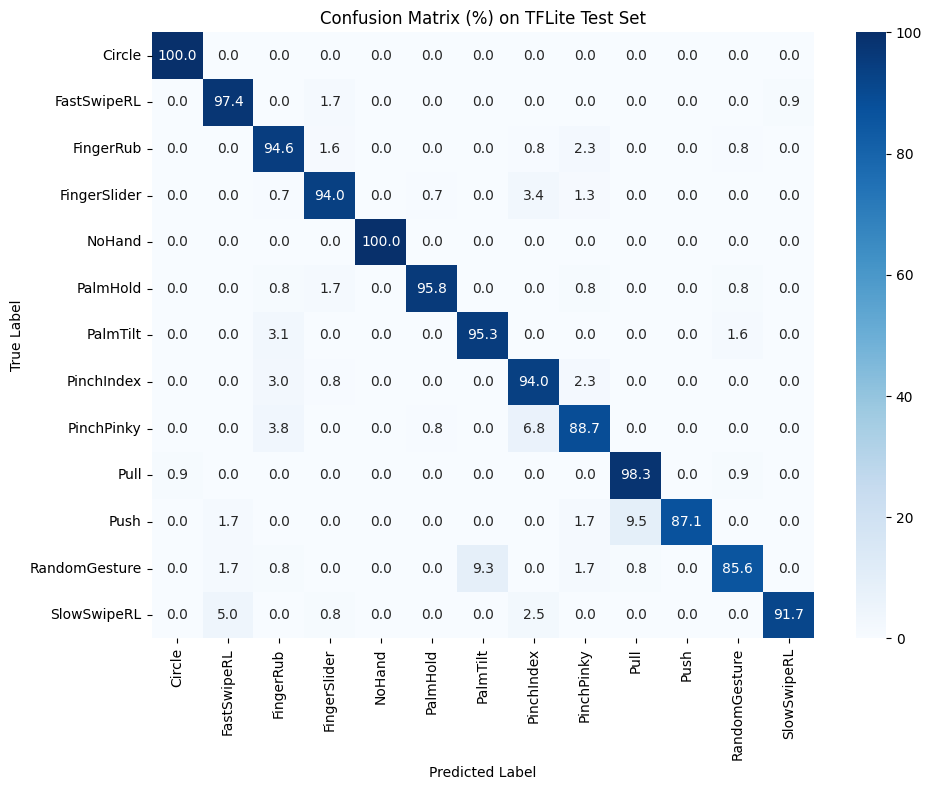

               precision    recall  f1-score   support

       Circle       0.99      1.00      1.00       123
  FastSwipeRL       0.92      0.97      0.95       115
    FingerRub       0.88      0.95      0.91       129
 FingerSlider       0.95      0.94      0.94       149
       NoHand       1.00      1.00      1.00       124
     PalmHold       0.98      0.96      0.97       119
     PalmTilt       0.92      0.95      0.93       127
   PinchIndex       0.87      0.94      0.91       133
   PinchPinky       0.90      0.89      0.89       133
         Pull       0.91      0.98      0.94       117
         Push       1.00      0.87      0.93       116
RandomGesture       0.95      0.86      0.90       118
  SlowSwipeRL       0.99      0.92      0.95       120

     accuracy                           0.94      1623
    macro avg       0.94      0.94      0.94      1623
 weighted avg       0.94      0.94      0.94      1623



In [61]:
def run_tflite_inference(rtm, dtm, atm):
    interpreter.set_tensor(input_details[0]['index'], rtm.astype(input_details[0]['dtype']))
    interpreter.set_tensor(input_details[1]['index'], dtm.astype(input_details[1]['dtype']))
    interpreter.set_tensor(input_details[2]['index'], atm.astype(input_details[2]['dtype']))
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    return output_data

# Collect predictions
y_true = []
y_pred = []

for X_batch, y_batch in val_gen:
    batch_size = X_batch[0].shape[0]
    for i in range(batch_size):
        rtm = X_batch[0][i:i+1]  # shape: (1, 5, 32, 32, 1)
        dtm = X_batch[1][i:i+1]
        atm = X_batch[2][i:i+1]
        output = run_tflite_inference(rtm, dtm, atm)
        y_pred.append(np.argmax(output))
        y_true.append(y_batch[i])

# Convert to arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Evaluate: confusion matrix and report
cm = confusion_matrix(y_true, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
gesture_names = list(label_map.keys())

plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=gesture_names, yticklabels=gesture_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (%) on TFLite Test Set')
plt.tight_layout()
plt.show()

print(classification_report(y_true, y_pred, target_names=gesture_names))

# Conversion to TFLite of Pruned Model

In [7]:
test_gen = MultiRadarSequenceGenerator(
    test_samples,
    label_map,
    batch_size=32,
    seq_len=SEQ_LEN,
    shuffle_data=False
)

In [ ]:
model_path = r'\Code\model_training\Good_Models\h5_models\mmWave_orig_pruned_float32.h5'
pruned_model = tf.keras.models.load_model(model_path)
model = tfmot.sparsity.keras.strip_pruning(pruned_model)

In [14]:
@tf.function(input_signature=[
    tf.TensorSpec(shape=[1, 5, 32, 32, 3], dtype=tf.float32, name="rtm"),
    tf.TensorSpec(shape=[1, 5, 32, 32, 3], dtype=tf.float32, name="dtm"),
    tf.TensorSpec(shape=[1, 5, 32, 32, 3], dtype=tf.float32, name="atm"),
])
def wrapped_model(rtm, dtm, atm):
    return model([rtm, dtm, atm])
concrete_func = wrapped_model.get_concrete_function()
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = []  # No quantization (pure float32)

tflite_model = converter.convert()

# Save
with open("mmWave_orig_pruned_float32.tflite", "wb") as f:
    f.write(tflite_model)

print("Saved: mmWave_orig_pruned_float32.tflite")

Saved: mmWave_orig_pruned_float32.tflite


# Float16 Quantization for pruned model

In [ ]:
model_path = r'\Code\model_training\Good_Models\h5_models\mmWave_orig_pruned_float32.h5'
pruned_model = tf.keras.models.load_model(model_path)
model = tfmot.sparsity.keras.strip_pruning(pruned_model)

In [19]:
@tf.function(input_signature=[
    tf.TensorSpec(shape=[1, 5, 32, 32, 3], dtype=tf.float32, name="rtm"),
    tf.TensorSpec(shape=[1, 5, 32, 32, 3], dtype=tf.float32, name="dtm"),
    tf.TensorSpec(shape=[1, 5, 32, 32, 3], dtype=tf.float32, name="atm"),
])
def wrapped_model(rtm, dtm, atm):
    return model([rtm, dtm, atm])
concrete_func = wrapped_model.get_concrete_function()

converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Enable float16 quantization
converter.target_spec.supported_types = [tf.float16]

# Still allow float32 inputs/outputs for compatibility
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32

# Convert
tflite_model_fp16 = converter.convert()
with open("mmWave_orig_pruned_float16.tflite", "wb") as f:
    f.write(tflite_model_fp16)

print("Saved: mmWave_orig_pruned_float16.tflite")


Saved: mmWave_orig_pruned_float16.tflite


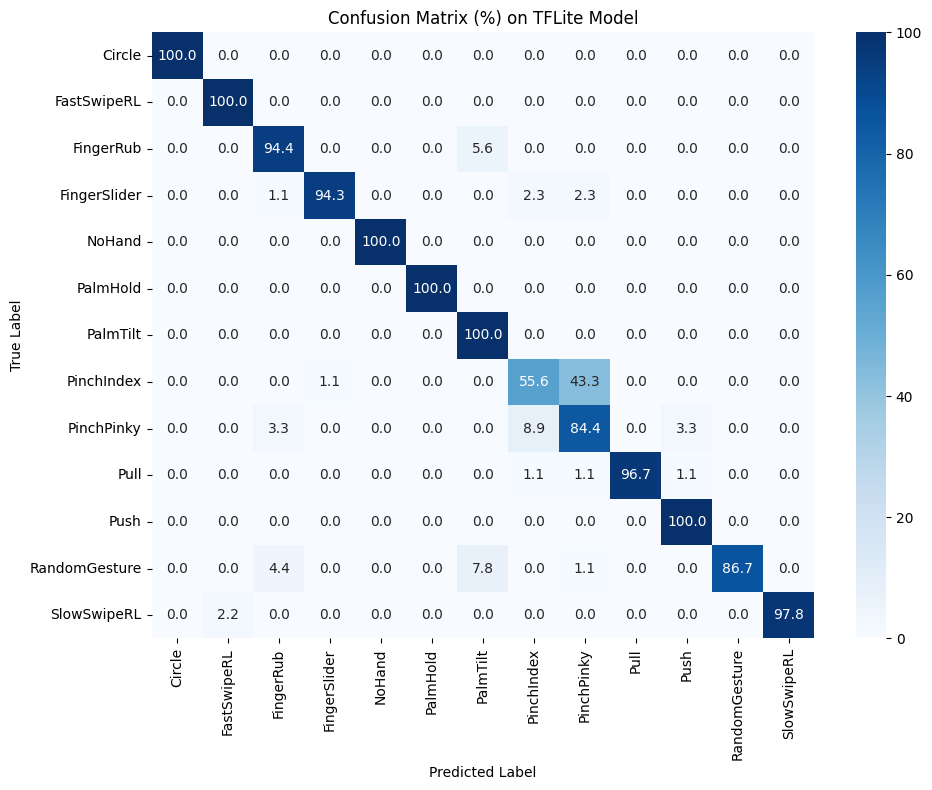


Classification Report:
               precision    recall  f1-score   support

       Circle     1.0000    1.0000    1.0000        90
  FastSwipeRL     0.9783    1.0000    0.9890        90
    FingerRub     0.9140    0.9444    0.9290        90
 FingerSlider     0.9880    0.9425    0.9647        87
       NoHand     1.0000    1.0000    1.0000        90
     PalmHold     1.0000    1.0000    1.0000        89
     PalmTilt     0.8824    1.0000    0.9375        90
   PinchIndex     0.8197    0.5556    0.6623        90
   PinchPinky     0.6387    0.8444    0.7273        90
         Pull     1.0000    0.9667    0.9831        90
         Push     0.9574    1.0000    0.9783        90
RandomGesture     1.0000    0.8667    0.9286        90
  SlowSwipeRL     1.0000    0.9778    0.9888        90

     accuracy                         0.9305      1166
    macro avg     0.9368    0.9306    0.9299      1166
 weighted avg     0.9366    0.9305    0.9297      1166



In [ ]:
interpreter = tf.lite.Interpreter(model_path="mmWave_orig_pruned_float16.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
y_true = []
y_pred = []

for X_batch, y_batch in test_gen:
    batch_size = len(y_batch)
    
    for i in range(batch_size):
        input_data = [
            X[i:i+1].astype(np.float32)
            for X in X_batch
        ]
        
        # Set input tensors
        for idx, detail in enumerate(input_details):
            interpreter.set_tensor(detail['index'], input_data[idx])

        interpreter.invoke()
        
        # Get output
        output = interpreter.get_tensor(output_details[0]['index'])
        predicted_label = np.argmax(output[0])

        y_true.append(y_batch[i])
        y_pred.append(predicted_label)

# Convert to arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
# Reverse label_map to get names
inv_label_map = {v: k for k, v in label_map.items()}
gesture_names = [inv_label_map[i] for i in sorted(inv_label_map)]

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=gesture_names, yticklabels=gesture_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (%) on TFLite Model')
plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=gesture_names, digits=4))


# Pruning for int8 model

In [6]:
test_gen = MultiRadarSequenceGenerator(
    test_samples,
    label_map,
    batch_size=32,
    seq_len=SEQ_LEN,
    shuffle_data=False
)

In [ ]:
def count_prunable_params(model):
    total_params = 0
    layer_info = []

    def collect_prunable_layers(layer):
        nonlocal total_params

        # Handle TimeDistributed or wrapper layers
        if isinstance(layer, tf.keras.layers.TimeDistributed):
            return collect_prunable_layers(layer.layer)
        elif isinstance(layer, tf.keras.Model):  # Handle nested models
            for sublayer in layer.layers:
                collect_prunable_layers(sublayer)
        elif isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.Dense)):
            params = layer.count_params()
            total_params += params
            layer_info.append((layer.name, params))
    
    for layer in model.layers:
        collect_prunable_layers(layer)

    print("=== Prunable Layer Summary ===")
    for name, params in layer_info:
        print(f"{name}: {params:,} parameters")
    print(f"Total prunable parameters: {total_params:,}")

# Usage
model = tf.keras.models.load_model(
    r"\Code\model_training\Good_Models\mmWave_orig_float32.h5"
)
count_prunable_params(model)

=== Prunable Layer Summary ===
conv2d_14: 1,216 parameters
dense_42: 524,416 parameters
conv2d_14: 1,216 parameters
dense_42: 524,416 parameters
conv2d_14: 1,216 parameters
dense_42: 524,416 parameters
dense_43: 8,256 parameters
dense_44: 845 parameters
Total prunable parameters: 1,585,997


In [ ]:
pruning_schedule = tfmot.sparsity.keras.PolynomialDecay(
    initial_sparsity=0.0,
    final_sparsity=0.5,
    begin_step=0,
    end_step=1000
)

# === Recursive pruning ===
def prune_recursively(layer):
    if isinstance(layer, tf.keras.models.Sequential):
        return tf.keras.Sequential([prune_recursively(l) for l in layer.layers])
    elif isinstance(layer, tf.keras.Model):
        return tf.keras.models.clone_model(layer, clone_function=prune_recursively)
    elif isinstance(layer, tf.keras.layers.TimeDistributed):
        layer.layer = prune_recursively(layer.layer)
        return layer
    elif isinstance(layer, (tf.keras.layers.Dense, tf.keras.layers.Conv2D)):
        return tfmot.sparsity.keras.prune_low_magnitude(layer, pruning_schedule)
    else:
        return layer

# === Clone and prune model ===
model_for_pruning = tf.keras.models.clone_model(model, clone_function=prune_recursively)
model_for_pruning.build(model.input_shape)

# === Copy weights recursively ===
def copy_weights_recursive(orig_layer, pruned_layer):
    if hasattr(orig_layer, 'layers') and hasattr(pruned_layer, 'layers'):
        for ol, pl in zip(orig_layer.layers, pruned_layer.layers):
            copy_weights_recursive(ol, pl)
    elif hasattr(orig_layer, 'layer') and hasattr(pruned_layer, 'layer'):
        copy_weights_recursive(orig_layer.layer, pruned_layer.layer)
    else:
        try:
            pruned_layer.set_weights(orig_layer.get_weights())
        except Exception as e:
            print(f"Could not copy weights for {pruned_layer.name}: {e}")

copy_weights_recursive(model, model_for_pruning)

# === Compile ===
model_for_pruning.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# === Required pruning callback ===
callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir="./prune_logs")
]

# === Train on CPU ===
with tf.device('/CPU:0'):
    model_for_pruning.fit(
        train_gen,
        validation_data=val_gen,
        epochs=5,
        callbacks=callbacks
    )

# === Strip pruning wrappers ===
stripped_model = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
stripped_model.save("pruned_model_final.h5")

Epoch 1/5
26/26 [==============================] - 48s 2s/step - loss: 0.1364 - accuracy: 0.9593 - val_loss: 0.1380 - val_accuracy: 0.9495
Epoch 2/5
26/26 [==============================] - 41s 2s/step - loss: 0.0150 - accuracy: 0.9965 - val_loss: 0.1001 - val_accuracy: 0.9655
Epoch 3/5
26/26 [==============================] - 41s 2s/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.0805 - val_accuracy: 0.9778
Epoch 4/5
26/26 [==============================] - 40s 2s/step - loss: 0.0019 - accuracy: 0.9998 - val_loss: 0.0707 - val_accuracy: 0.9778
Epoch 5/5
26/26 [==============================] - 39s 1s/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0675 - val_accuracy: 0.9815


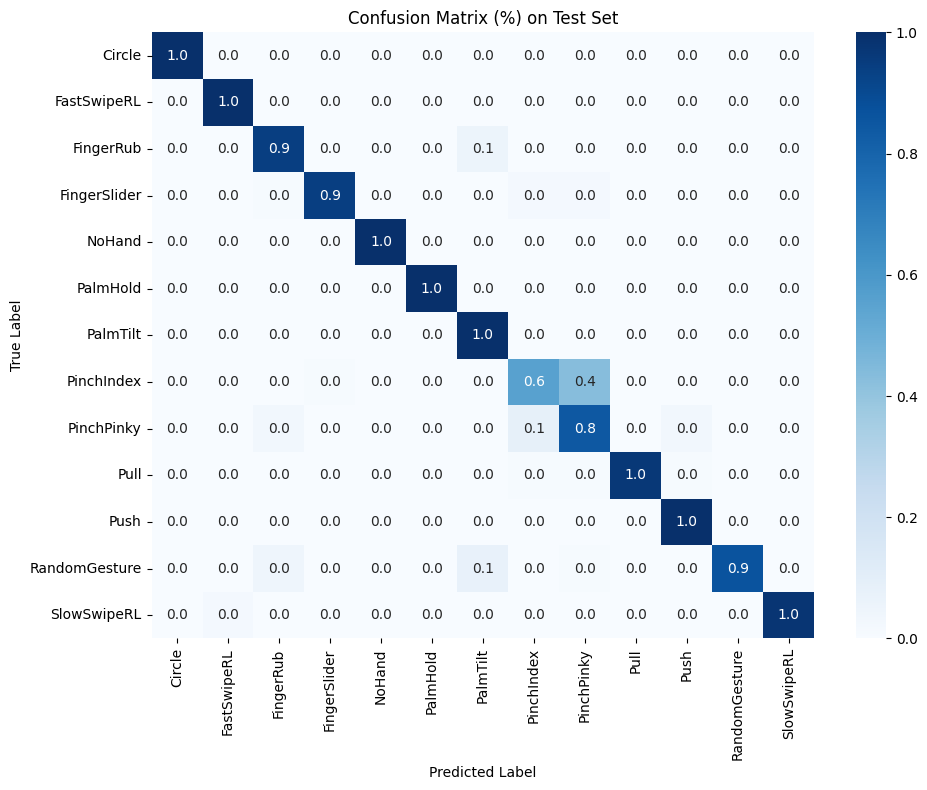

               precision    recall  f1-score   support

       Circle       1.00      1.00      1.00        90
  FastSwipeRL       0.98      1.00      0.99        90
    FingerRub       0.91      0.94      0.93        90
 FingerSlider       0.99      0.94      0.96        87
       NoHand       1.00      1.00      1.00        90
     PalmHold       1.00      1.00      1.00        89
     PalmTilt       0.88      1.00      0.94        90
   PinchIndex       0.82      0.56      0.66        90
   PinchPinky       0.64      0.84      0.73        90
         Pull       1.00      0.97      0.98        90
         Push       0.96      1.00      0.98        90
RandomGesture       1.00      0.87      0.93        90
  SlowSwipeRL       1.00      0.98      0.99        90

     accuracy                           0.93      1166
    macro avg       0.94      0.93      0.93      1166
 weighted avg       0.94      0.93      0.93      1166



In [ ]:
model = tf.keras.models.load_model("pruned_model_final.h5")
test_gen = MultiRadarSequenceGenerator(
    test_samples,
    label_map,
    batch_size=32,
    seq_len=SEQ_LEN,
    shuffle_data=False
)

best_model_path = r'\Code\model_training\Models\3_radar_CNN\final_model.h5'
model = tf.keras.models.load_model("pruned_model_final.h5")

# Predict on test generator
y_true = []
y_pred = []

for X, y in test_gen:
    preds = model.predict(X, verbose=0)
    y_true.extend(y)
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True)
gesture_names = list(label_map.keys())

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=gesture_names, yticklabels=gesture_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (%) on Test Set')
plt.tight_layout()
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=gesture_names))

In [ ]:
model_path = r'\Code\model_training\Good_Models\mmWave_pruned_model_float32.h5'

In [ ]:
# === 1. Dynamically get PruneLowMagnitude class ===
dummy = tfmot.sparsity.keras.prune_low_magnitude(tf.keras.layers.Dense(1), input_shape=(1,))
PruneLowMagnitude = type(dummy)

# === 2. Load the model with custom object mapping ===
model = tf.keras.models.load_model(
    r'\Code\model_training\Good_Models\mmWave_pruned_model_float32.h5',
    custom_objects={'PruneLowMagnitude': PruneLowMagnitude}
)

# === 3. Strip pruning wrappers (critical before converting) ===
model = tfmot.sparsity.keras.strip_pruning(model)

# === 4. Wrap model in concrete function ===
@tf.function(input_signature=[
    tf.TensorSpec(shape=[1, 5, 32, 32, 3], dtype=tf.float32, name="rtm_input"),
    tf.TensorSpec(shape=[1, 5, 32, 32, 3], dtype=tf.float32, name="dtm_input"),
    tf.TensorSpec(shape=[1, 5, 32, 32, 3], dtype=tf.float32, name="atm_input")
])
def wrapped_model(rtm, dtm, atm):
    return model([rtm, dtm, atm])

concrete_func = wrapped_model.get_concrete_function()

# === 5. Define representative dataset ===
def representative_dataset():
    for X_batch, _ in test_gen:  # Ensure this is defined
        for i in range(min(len(X_batch[0]), 100)):
            rtm = X_batch[0][i:i+1].astype(np.float32)
            dtm = X_batch[1][i:i+1].astype(np.float32)
            atm = X_batch[2][i:i+1].astype(np.float32)
            yield [rtm, dtm, atm]

# === 6. Convert to INT8 TFLite ===
converter = tf.lite.TFLiteConverter.from_concrete_functions(
    [concrete_func], model  # Pass `model` as `trackable_obj` to avoid the warning
)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS_INT8,
    tf.lite.OpsSet.SELECT_TF_OPS
]
converter._experimental_lower_tensor_list_ops = False

# === 7. Convert and save ===
tflite_model = converter.convert()
with open("pruned_quantized_model_int8.tflite", "wb") as f:
    f.write(tflite_model)

print("Model converted to INT8 and saved.")

In [ ]:
best_model_path = r'\Code\model_training\Good_Models\mmWave_orig_float32.h5'
model = tf.keras.models.load_model(best_model_path)
# Count weights
total_weights = 0
nonzero_weights = 0

for layer in model.layers:
    for weight in layer.get_weights():
        total_weights += weight.size
        nonzero_weights += np.count_nonzero(weight)

# Compute storage assuming INT8 (1 byte per weight)
theoretical_size_bytes = nonzero_weights  # 1 byte per non-zero
theoretical_size_kb = theoretical_size_bytes / 1024

# Optional: full model size if fully dense INT8
full_dense_size_kb = total_weights / 1024

print(f"Estimated model size (pruned, INT8): {theoretical_size_kb:.2f} KB")
print(f"Theoretical dense INT8 size: {full_dense_size_kb:.2f} KB")

Estimated model size (pruned, INT8): 1805.33 KB
Theoretical dense INT8 size: 1805.33 KB
